In [ ]:
#Se importa el paquete pandas
import pandas as pd
#Se carga los datos de las ventas que son la variable objetivo
df=pd.read_csv("/content/sales data-set.csv", sep=",")
df.head()

In [ ]:
df.shape

Se ve que son 421570 registros de 5 variables

In [ ]:
#se carga la base de datos de las cacteristicas para hacer el pronostico
df2=pd.read_csv("/content/Features data set.csv", sep=",")
#Se elminan las varibales que contienen valores nulos
df2=df2.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"], axis=1)
df2.head()

In [ ]:
df2.shape

Son 8190 registro de 7 variables

La extensión de las caracteristicas y de la variable objetivo no son los mismos. Se crea una llave principal para combinar los datos, dicha llave principal es la unión de la fecha y la tienda. Como el departamento no se encuentra en la base de datos de las caracteristicas no se puede usar

In [ ]:
df["id"]=df["Store"].map(str)+df["Date"]
df.head()

In [ ]:
df2["id"]=df["Store"].map(str)+df["Date"]
df2.head()

In [ ]:
#Se unen las bases de datos donde coincide la fecha y la tienda, que se encuentren dentro de ambas bases
#Se hace un matcheo muchos a muchos
Entreno=pd.merge(df2,df, on="id",how="inner",validate="many_to_many")
Entreno.head()

In [105]:
#Se eliminan las variables reptidas
Entreno=Entreno.drop(["Store_y","Dept","Date_y","id","Date_x"],axis=1)
#Se eliminan los valores nullos en cualqueir columna
Entreno = Entreno.dropna()
Entreno.shape

(544917, 8)

In [ ]:
#Se renombra la variable Store_x para que coincida con la base de testeo
#es posible que esta variable no arroje mucha info en el pronostico y se evalue eliminarla
Entreno=Entreno.rename(columns={'Store_x':"Store"})
Entreno.head()

In [110]:
#Se ve el orden de las columnas para sincronizarlo con el archivo de testeo
Entreno.columns

Index(['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday_x', 'Weekly_Sales', 'IsHoliday_y'],
      dtype='object')

Importar la base de datos de testeo

In [111]:
Test=pd.read_csv("/content/Tabla_1.csv", sep=",")
#Se elimina la primera variable que no tiene nombre
Test=Test.iloc[:,1:]
#Se eliminan las variables nulas
Test=Test.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5","Dept","Date"], axis=1)

In [ ]:
#se elimina los registros nulos en cualquier columna
Test = Test.dropna()
#Se reordenan las columnas
Test=Test[['Store', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
       'IsHoliday_x', 'Weekly_Sales', 'IsHoliday_y']]
Test.head()

In [ ]:
#Se realiza los histogramas de las variables continuas
Entreno.Weekly_Sales.hist()

In [ ]:
Entreno.Temperature.hist()

In [ ]:
Entreno.Fuel_Price.hist()

In [ ]:
Entreno.CPI.hist()

In [ ]:
Entreno.Unemployment.hist()

In [ ]:
#Histograma para las variables categoricas
import seaborn as sb
sb.factorplot('Store',data=Entreno,kind="count", aspect=2)

In [ ]:
print(Entreno.groupby('Store').size())

In [ ]:
sb.factorplot('IsHoliday_x',data=Entreno,kind="count", aspect=2)

In [ ]:
print(Entreno.groupby('IsHoliday_x').size())

K-Nearest Neighbor

In [ ]:
#Se instala el paquete requerido
pip install sklearn

In [136]:
#Se hace las importaciones necesarias
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

La division de los datos

In [ ]:
#Se dividen los datos. 
#Los valores de x para el entranamientos será la base de datos de entrenamiento sin las ventas semanales
xEntreno=Entreno.drop(["Weekly_Sales"], axis=1)
xEntreno.head()

In [ ]:
#La y de entrenamiento será las ventas semanales de entrenamiento
yEntreno=Entreno["Weekly_Sales"]
yEntreno.head()

In [141]:
#Esto convierte los valores en arrays para ser usados en el modelo
xEntreno=xEntreno.values
yEntreno=yEntreno.values

In [ ]:
#Los valores x de testeo serán la base de testeo sin las ventas semanales
xTest=Test.drop(["Weekly_Sales"], axis=1)
xTest.head()

In [ ]:
#La y de testeo seran las ventas semanales del archivo de testeo
yTest=Test["Weekly_Sales"]
yTest.head()

In [144]:
#Esto covierte los datos en arrays para usados en el modelo
xTest=xTest.values
yTest=yTest.values

In [145]:
#Esto genera una escala en tre 0 y 1
escala = MinMaxScaler()
print(escala)

MinMaxScaler(copy=True, feature_range=(0, 1))


In [146]:
#Esto normaliza los valores usando la escala anteriormente creada
xEntreno = escala.fit_transform(xEntreno)
xTest=escala.transform(xTest)

Aplicación del KNN

In [147]:
#Se toma a priori como paramatreo los tres vecinos más cercanos
nvecinos=3
KNN = KNeighborsRegressor(n_neighbors=nvecinos)
KNN.fit(xEntreno,yEntreno)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [ ]:
import matplotlib.pyplot as plt
#Se crea la predicción y se compara con los valores reales
p11 = KNN.predict(xTest) #predicción
p11

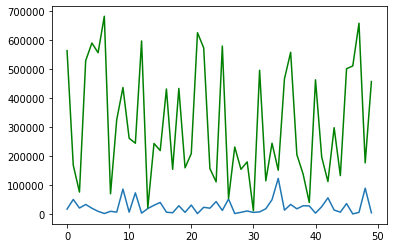

In [149]:
plt.plot(p11)
plt.plot(yTest, color="green")
#El valor azul es el pronostico y el verde es el observado

In [169]:
from sklearn.metrics import mean_squared_error
from math import sqrt
#promedio del error al cuadrado
cem1=mean_squared_error(yTest,p11)
#raiz
rcem1=sqrt(cem1)
rcem1

352967.4740126683

In [ ]:
#Se hace una validación cruzada par determinar que parametros es óptimo, particularemte el número de vecinos
parametros = {"n_neighbors": range(1, 3)}
gr= GridSearchCV(KNeighborsRegressor(), parametros,n_jobs=-1,cv=2,refit=False)
gr.fit(xEntreno, yEntreno)

In [156]:
gr.best_params_

{'n_neighbors': 2}

Se encuentra que nivel optimo de vecinos es 2.

In [ ]:
#Se repite el procedimiento solo que en vez de una validación cruzada se lleva a cabo aleatoriamente
#Se establece el estado alatroio en cero
parametros = {"n_neighbors": range(1, 3)}
rgr= RandomizedSearchCV(KNeighborsRegressor(), parametros,n_jobs=-1,cv=2,refit=False,random_state=0 )
rgr.fit(xEntreno, yEntreno)
#Esto se hace para confirmar la validación cruzada ya que la valida cruzada requiere más tiempo y recursos

In [160]:
rgr.best_params_
#El mejor parametro es dos vecinos

{'n_neighbors': 2}

KNN otros prametros

In [162]:
#Se repite el KNN solo que ahora con 2 vecinos y el algoritmo en vez de automatico se útiliza ball tree
nvecinos=2
KNN = KNeighborsRegressor(n_neighbors=nvecinos, algorithm='ball_tree')
KNN.fit(xEntreno,yEntreno)

KNeighborsRegressor(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [ ]:
p12 = KNN.predict(xTest) #predicción
p12
#Se realiza la predicción

In [ ]:
plt.plot(p12)
plt.plot(yTest, color="green")
#El valor azul es el pronostico y el verde es el observado

In [170]:
#promedio del error al cuadrado
cem2=mean_squared_error(yTest,p12)
#raiz
rcem2=sqrt(cem2)
rcem2

351945.45434044074

In [171]:
#Se repite KNN pero ahora con Kd Tree
nvecinos=2
KNN = KNeighborsRegressor(n_neighbors=nvecinos, algorithm='kd_tree')
KNN.fit(xEntreno,yEntreno)

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [ ]:
#Se crea la predicción y se compara con los valores reales
p13 = KNN.predict(xTest) #predicción
p13

In [ ]:
plt.plot(p13)
plt.plot(yTest, color="green")
#El valor azul es el pronostico y el verde es el observado

In [174]:
#promedio del error al cuadrado
cem3=mean_squared_error(yTest,p13)
#raiz
rcem3=sqrt(cem3)
rcem3

352447.1645693062

Ramdon Forest

In [ ]:
#se hace la importación necesaria
from sklearn.ensemble import RandomForestRegressor
#se establecen los parametros del modelo. Se estima 100 arboles donde el criterio es el error medio al cuadrado, y no se limita el largo del arbol
RDF = RandomForestRegressor(n_estimators=100, criterion="mse", bootstrap = True, verbose=2,max_features = 'sqrt', random_state=0)
RDF.fit(xEntreno, yEntreno)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


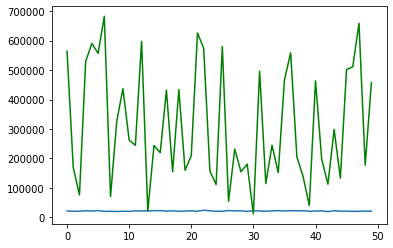

In [189]:
#Se realiza la predicción
p21=RDF.predict(xTest)
plt.plot(p21)
plt.plot(yTest, color="green")
#La líena azul es la predicción y la verde son los valores observados

In [190]:
#promedio del erro cuadrado
cem4=mean_squared_error(yTest,p21)
#raiz
rcem4=sqrt(cem4)
rcem4

351341.9192798729

In [191]:
#se importa la función necesaria para exportar el árbol
from sklearn.tree import export_graphviz
import pydot
arbol = RDF.estimators_[2] #se crea el arbol con dos estimadores
arbol

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=924231285, splitter='best')

In [192]:
#se crea el arbol.dot y luego se convierte en un png
export_graphviz(arbol, out_file = 'arbol.dot',rounded = True, precision = 1)
(grafica, ) = pydot.graph_from_dot_file('arbol.dot')
grafica.write_png('arbol.png')

In [ ]:
#Se repite la estimación pero esta vez limitando la extensión a 3 niveles max_depth=3
RDF2 = RandomForestRegressor(n_estimators=100, criterion="mse", bootstrap = True, verbose=2,max_features = 'sqrt', random_state=0,max_depth=3)
RDF2.fit(xEntreno,yEntreno)

In [194]:
arbol2 = RDF2.estimators_[6]
arbol2 #se crea un segundo arbol

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=192771779, splitter='best')

In [195]:
#Se exporta en un archivo. dot
export_graphviz(arbol2, out_file = 'arbol2.dot', rounded = True, precision = 1)

In [196]:
(grafica, ) = pydot.graph_from_dot_file('arbol2.dot') #luego se transporma en png
grafica.write_png('arbol2.png')

In [ ]:
p22=RDF2.predict(xTest)
plt.plot(p22)
plt.plot(yTest, color="green")

In [203]:
#promedio del error cuadrado
cem5=mean_squared_error(yTest,p22)
#raiz
rcem5=sqrt(cem5)
rcem5

351378.8293891926

In [204]:
#Se vuelve a estimar el ramdon forest pero s estiman 1000 arboles 
RDF3 = RandomForestRegressor(n_estimators=1000, criterion="mse", bootstrap = True, verbose=2,max_features = 'sqrt', random_state=0,max_depth=3)

In [206]:
RDF3.fit(xEntreno,yEntreno)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 1000
building tree 2 of 1000
building tree 3 of 1000
building tree 4 of 1000
building tree 5 of 1000
building tree 6 of 1000
building tree 7 of 1000
building tree 8 of 1000
building tree 9 of 1000
building tree 10 of 1000
building tree 11 of 1000
building tree 12 of 1000
building tree 13 of 1000
building tree 14 of 1000
building tree 15 of 1000
building tree 16 of 1000
building tree 17 of 1000
building tree 18 of 1000
building tree 19 of 1000
building tree 20 of 1000
building tree 21 of 1000
building tree 22 of 1000
building tree 23 of 1000
building tree 24 of 1000
building tree 25 of 1000
building tree 26 of 1000
building tree 27 of 1000
building tree 28 of 1000
building tree 29 of 1000
building tree 30 of 1000
building tree 31 of 1000
building tree 32 of 1000
building tree 33 of 1000
building tree 34 of 1000
building tree 35 of 1000
building tree 36 of 1000
building tree 37 of 1000
building tree 38 of 1000
building tree 39 of 1000
building tree 40 of 1000
building 

[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  2.1min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=2, warm_start=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.1s finished


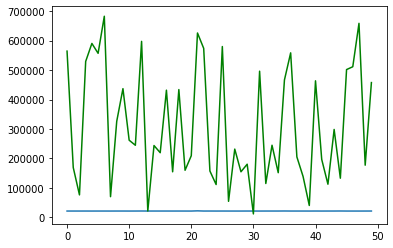

In [207]:
p23=RDF3.predict(xTest)
plt.plot(p23)
plt.plot(yTest, color="green")

In [82]:
#promedio del erro cuadrado
cem6=mean_squared_error(yTest, p23)
#raiz
rcem6=sqrt(cem6)
rcem6

351391.8809020552

In [208]:
arbol3 = RDF3.estimators_[6]
arbol3 # se crea el tercer arbol 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=3,
                      max_features='sqrt', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=192771779, splitter='best')

In [209]:
export_graphviz(arbol3, out_file = 'arbol3.dot', rounded = True, precision = 1)
(grafica, ) = pydot.graph_from_dot_file('arbol3.dot')
grafica.write_png('arbol3.png')
#se esporta en png

In [210]:
#Se crea el vector de los errores de cada uno de los modelos
vector_errores=[rcem1,rcem2,rcem3,rcem4,rcem5,rcem6]
menor_error=min(vector_errores)#se determina cual es menor
menor_error


351341.9192798729

In [211]:
#se crea un directorio con cada modelo
directorio={rcem1:"KNN", rcem2:"KNN2", rcem3:"KNN3", rcem4:"RDF",rcem5:"RDF2",rcem6:"RDF3"}
directorio[menor_error]
#Al conusultar cual es el menor error se arroja que es ramdon forest de 100 arboles sin recortar.

'RDF'